# Project: No-Show Medical Appointments Data Investigation by Aysu Erdemir

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction
In this project we wil be analyzing the data associated with 100k medical appointments in Brazil to see if whether people show up for their appoitnments or not is associated with any other factors coded in the data. In particular we will be interested in finding trends among the patients who do not show up for their appointment and how they are different from the patients who show up for their appointments. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

### General Properties

In [3]:
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [4]:
df.shape
# Data has 110527 rows (patients) and 14 variables. 

(110527, 14)

In [5]:
# Let's convert all column names into lowercase for consistency
df.rename(columns = lambda x:x.strip().lower(), inplace=True)

In [77]:
# Let's correct the typos and remove _ and - for consistency among the column names. 
df.rename(columns = {'hipertension':'hypertension','handcap':'handicap','sms_received':'smsreceived','no-show':'noshow'}, inplace=True)

In [78]:
# Let's see if there is anything wrong about the data types. 
df.dtypes

patientid         float64
appointmentid       int64
gender             object
scheduledday       object
appointmentday     object
age                 int64
neighbourhood      object
scholarship         int64
hypertension        int64
diabetes            int64
alcoholism          int64
handicap            int64
smsreceived         int64
noshow             object
dtype: object

In [79]:
# Let's change scheduledDay and AppointmentDay (string) into the "date format". 
df['scheduledday'] = pd.to_datetime(df['scheduledday'])
df['appointmentday'] = pd.to_datetime(df['appointmentday'])

In [80]:
# let's make sure the changes are made
df.dtypes

patientid                     float64
appointmentid                   int64
gender                         object
scheduledday      datetime64[ns, UTC]
appointmentday    datetime64[ns, UTC]
age                             int64
neighbourhood                  object
scholarship                     int64
hypertension                    int64
diabetes                        int64
alcoholism                      int64
handicap                        int64
smsreceived                     int64
noshow                         object
dtype: object

In [81]:
# Let's see how many unique values there are for each variable. 
df.nunique()

patientid          62299
appointmentid     110527
gender                 2
scheduledday      103549
appointmentday        27
age                  104
neighbourhood         81
scholarship            2
hypertension           2
diabetes               2
alcoholism             2
handicap               5
smsreceived            2
noshow                 2
dtype: int64

Based on this output we can  see that many of the variables are binary (0,1) having two values for the absence of presence of the trait - except handicap which has 5 values. Let's explore handicap in more detail. 

Based on this output there are 62299 unique patient IDs but 110527 unique appt IDs. One interesting inference we can make is that there are more appointments than there are patients, possibly indicating that many patients had multiple appointments at different times. Let'e explore this in more detail. 

In [82]:
# The documentation mentions that the variable "handicap" should be binary but exploring it in more detail, 
# it seems like it takes values between 0-5, possibly depending on the severity of the handicap. We will keep it as is.
df['handicap'].value_counts()

0    108286
1      2042
2       183
3        13
4         3
Name: handicap, dtype: int64

In [83]:
# change the patientid column into string to improve readability. 
df['patientid']= df['patientid'].astype(str)

In [84]:
# Let's see how many duplicates there are
df['patientid'].duplicated()
# For example the last two patients are a duplicate

0         False
1         False
2         False
3         False
4         False
          ...  
110522     True
110523     True
110524    False
110525     True
110526     True
Name: patientid, Length: 110527, dtype: bool

In [85]:
# finding the patientid for the last two rows
df.tail(2)

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,smsreceived,noshow
110525,92134931435557.0,5630323,F,2016-04-27 15:09:23+00:00,2016-06-07 00:00:00+00:00,38,MARIA ORTIZ,0,0,0,0,0,1,No
110526,377511518121127.0,5629448,F,2016-04-27 13:30:56+00:00,2016-06-07 00:00:00+00:00,54,MARIA ORTIZ,0,0,0,0,0,1,No


In [86]:
df.query('patientid=="377511518121127.0"')
# this patient had 2 different appointments.

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,smsreceived,noshow
41009,377511518121127.0,5538529,F,2016-04-01 12:38:13+00:00,2016-05-04 00:00:00+00:00,54,MARIA ORTIZ,0,0,0,0,0,1,No
110526,377511518121127.0,5629448,F,2016-04-27 13:30:56+00:00,2016-06-07 00:00:00+00:00,54,MARIA ORTIZ,0,0,0,0,0,1,No


In [87]:
df.query('patientid=="3596266328735.0"')
# this patient had 4 different appointments. 

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,smsreceived,noshow
915,3596266328735.0,5637984,F,2016-04-29 07:35:40+00:00,2016-04-29 00:00:00+00:00,51,MARIA ORTIZ,0,0,0,0,0,0,No
60707,3596266328735.0,5558973,F,2016-04-08 07:13:33+00:00,2016-05-02 00:00:00+00:00,51,MARIA ORTIZ,0,0,0,0,0,0,Yes
98678,3596266328735.0,5662056,F,2016-05-05 08:03:27+00:00,2016-06-03 00:00:00+00:00,51,MARIA ORTIZ,0,0,0,0,0,1,No
110523,3596266328735.0,5650093,F,2016-05-03 07:27:33+00:00,2016-06-07 00:00:00+00:00,51,MARIA ORTIZ,0,0,0,0,0,1,No


### SIDE NOTE:
It seems like there are many REPEAT visits from the same patients. Ideally we should have used only 1 data point from each patient, because it would violate the assumption of the independence of data. However, for the time being  I will ignore this since we will mainly focus on the variables such as SMSreceived or time variables which seem to be different for each seperate row. Ideally only one data point from each patient should have been used when exploring the effect of gender, age or any other health related variable on show/noshow.

In [88]:
# Let's drop PatientID and AppointmentID since these are very specific to each patient. 
df.drop(['patientid', 'appointmentid'], axis =1, inplace=True)

In [89]:
# Let's explore some more:
df.describe()
# There is something wrong with Age, it cannot have a value of -1. 

,age,scholarship,hypertension,diabetes,alcoholism,handicap,smsreceived
count,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [90]:
df['age'].value_counts()
# there is only one data point with age -1. 

 0      3539
 1      2273
 52     1746
 49     1652
 53     1651
        ... 
 115       5
 100       4
 102       2
 99        1
-1         1
Name: age, Length: 104, dtype: int64

In [91]:
df.query('age == -1')

,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,smsreceived,noshow
99832,F,2016-06-06 08:58:13+00:00,2016-06-06 00:00:00+00:00,-1,ROMÃO,0,0,0,0,0,0,No


In [92]:
# remove the row with the index number 99832 (age= -1)
df = df.drop(99832)

In [93]:
df.shape

(110526, 12)

In [94]:
df.info()
# No null values. 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110526 entries, 0 to 110526
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   gender          110526 non-null  object             
 1   scheduledday    110526 non-null  datetime64[ns, UTC]
 2   appointmentday  110526 non-null  datetime64[ns, UTC]
 3   age             110526 non-null  int64              
 4   neighbourhood   110526 non-null  object             
 5   scholarship     110526 non-null  int64              
 6   hypertension    110526 non-null  int64              
 7   diabetes        110526 non-null  int64              
 8   alcoholism      110526 non-null  int64              
 9   handicap        110526 non-null  int64              
 10  smsreceived     110526 non-null  int64              
 11  noshow          110526 non-null  object             
dtypes: datetime64[ns, UTC](2), int64(7), object(3)
memory usage: 11.0+ MB


In [95]:
# confirming there are there no null values.
df.isnull().sum()

gender            0
scheduledday      0
appointmentday    0
age               0
neighbourhood     0
scholarship       0
hypertension      0
diabetes          0
alcoholism        0
handicap          0
smsreceived       0
noshow            0
dtype: int64

In [96]:
# Let's change 'gender' and 'noshow' data formats (str) into binary (int) for ease of analysis. 

In [97]:
# For the gender column, change M and F, to 1 and 0 for clarity and ease with future visualizations
df.loc[df['gender'] == 'M', ['gender']] = 1
df.loc[df['gender'] == 'F', ['gender']] = 0

In [98]:
# convert string into integer (binary)
df.gender= df.gender.astype(int) 

In [99]:
# For the noshow column, change Yes and No to 1 and 0 for clarity and ease with future visualizations
# Based ont this a person with 1 with be identified as a noshow, a person with 0 will be identified as a show. 
df.loc[df['noshow'] == 'Yes', ['noshow']] = 1
df.loc[df['noshow'] == 'No', ['noshow']] = 0

In [100]:
# convert string into integer (binary)
df['noshow'] = df['noshow'].astype(int) 

In [101]:
# makes sure changes are made
df['gender'], df['noshow']

(0         0
 1         1
 2         0
 3         0
 4         0
          ..
 110522    0
 110523    0
 110524    0
 110525    0
 110526    0
 Name: gender, Length: 110526, dtype: int64,
 0         0
 1         0
 2         0
 3         0
 4         0
          ..
 110522    0
 110523    0
 110524    0
 110525    0
 110526    0
 Name: noshow, Length: 110526, dtype: int64)

In [102]:
df.head(10)

,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,smsreceived,noshow
0,0,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,0
1,1,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,0
2,0,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,0
3,0,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0
4,0,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,0
5,0,2016-04-27 08:36:51+00:00,2016-04-29 00:00:00+00:00,76,REPÚBLICA,0,1,0,0,0,0,0
6,0,2016-04-27 15:05:12+00:00,2016-04-29 00:00:00+00:00,23,GOIABEIRAS,0,0,0,0,0,0,1
7,0,2016-04-27 15:39:58+00:00,2016-04-29 00:00:00+00:00,39,GOIABEIRAS,0,0,0,0,0,0,1
8,0,2016-04-29 08:02:16+00:00,2016-04-29 00:00:00+00:00,21,ANDORINHAS,0,0,0,0,0,0,0
9,0,2016-04-27 12:48:25+00:00,2016-04-29 00:00:00+00:00,19,CONQUISTA,0,0,0,0,0,0,0


We do not need appointmentday and scheduledday for our analysis, but let's calculate the difference between scheduled and appointment date since this might be an important indicator for show/noshow. One could expect that as the time between scheduled day and appointment day increases people would be more prone to miss their apppointment. 

In [103]:
# Let's check out the data format first
df['appointmentday']
# The date.time format has 0's only for the time segment. 
# Apparenty time information was not registered properly so let's remove them. 

0        2016-04-29 00:00:00+00:00
1        2016-04-29 00:00:00+00:00
2        2016-04-29 00:00:00+00:00
3        2016-04-29 00:00:00+00:00
4        2016-04-29 00:00:00+00:00
                    ...           
110522   2016-06-07 00:00:00+00:00
110523   2016-06-07 00:00:00+00:00
110524   2016-06-07 00:00:00+00:00
110525   2016-06-07 00:00:00+00:00
110526   2016-06-07 00:00:00+00:00
Name: appointmentday, Length: 110526, dtype: datetime64[ns, UTC]

In [104]:
df['scheduledday']
# this one seems to have intact time information 

0        2016-04-29 18:38:08+00:00
1        2016-04-29 16:08:27+00:00
2        2016-04-29 16:19:04+00:00
3        2016-04-29 17:29:31+00:00
4        2016-04-29 16:07:23+00:00
                    ...           
110522   2016-05-03 09:15:35+00:00
110523   2016-05-03 07:27:33+00:00
110524   2016-04-27 16:03:52+00:00
110525   2016-04-27 15:09:23+00:00
110526   2016-04-27 13:30:56+00:00
Name: scheduledday, Length: 110526, dtype: datetime64[ns, UTC]

In [105]:
# Let's convert datetime to just "date" for both variables for consistency
df['appointmentday']= pd.to_datetime(df['appointmentday']).dt.date 
df['scheduledday']= pd.to_datetime(df['scheduledday']).dt.date 

In [106]:
df['appointmentday'] , df['scheduledday']

(0         2016-04-29
 1         2016-04-29
 2         2016-04-29
 3         2016-04-29
 4         2016-04-29
              ...    
 110522    2016-06-07
 110523    2016-06-07
 110524    2016-06-07
 110525    2016-06-07
 110526    2016-06-07
 Name: appointmentday, Length: 110526, dtype: object,
 0         2016-04-29
 1         2016-04-29
 2         2016-04-29
 3         2016-04-29
 4         2016-04-29
              ...    
 110522    2016-05-03
 110523    2016-05-03
 110524    2016-04-27
 110525    2016-04-27
 110526    2016-04-27
 Name: scheduledday, Length: 110526, dtype: object)

In [107]:
# Let's calculate the difference between scheduled and appointment date and create a new variable called "timedifference".
df['timedifference']= (df['appointmentday']-df['scheduledday']).dt.days # we want the difference in "days" only. 

In [108]:
df['timedifference'].describe()
# Seems like there are some negative values, which cannot be correct. 

count    110526.000000
mean         10.183794
std          15.255034
min          -6.000000
25%           0.000000
50%           4.000000
75%          15.000000
max         179.000000
Name: timedifference, dtype: float64

In [109]:
neg = df.query('timedifference < 0')
neg
# there are 5 rows with 'negative' values for the timedifference data. Let's remove those rows. 

,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,smsreceived,noshow,timedifference
27033,1,2016-05-10,2016-05-09,38,RESISTÊNCIA,0,0,0,0,1,0,1,-1
55226,0,2016-05-18,2016-05-17,19,SANTO ANTÔNIO,0,0,0,0,1,0,1,-1
64175,0,2016-05-05,2016-05-04,22,CONSOLAÇÃO,0,0,0,0,0,0,1,-1
71533,0,2016-05-11,2016-05-05,81,SANTO ANTÔNIO,0,0,0,0,0,0,1,-6
72362,1,2016-05-04,2016-05-03,7,TABUAZEIRO,0,0,0,0,0,0,1,-1


In [110]:
# Drop the rows with negative values
df.drop(neg.index, inplace=True)

In [111]:
# Drop appointmentday and scheduledday since we do not need them any more
df.drop(['appointmentday', 'scheduledday'], axis=1, inplace=True)

In [112]:
df.shape
# We have removed 6 rows total. 

(110521, 11)

In [113]:
# create a clean copy of the data frame
df1 = df.copy()

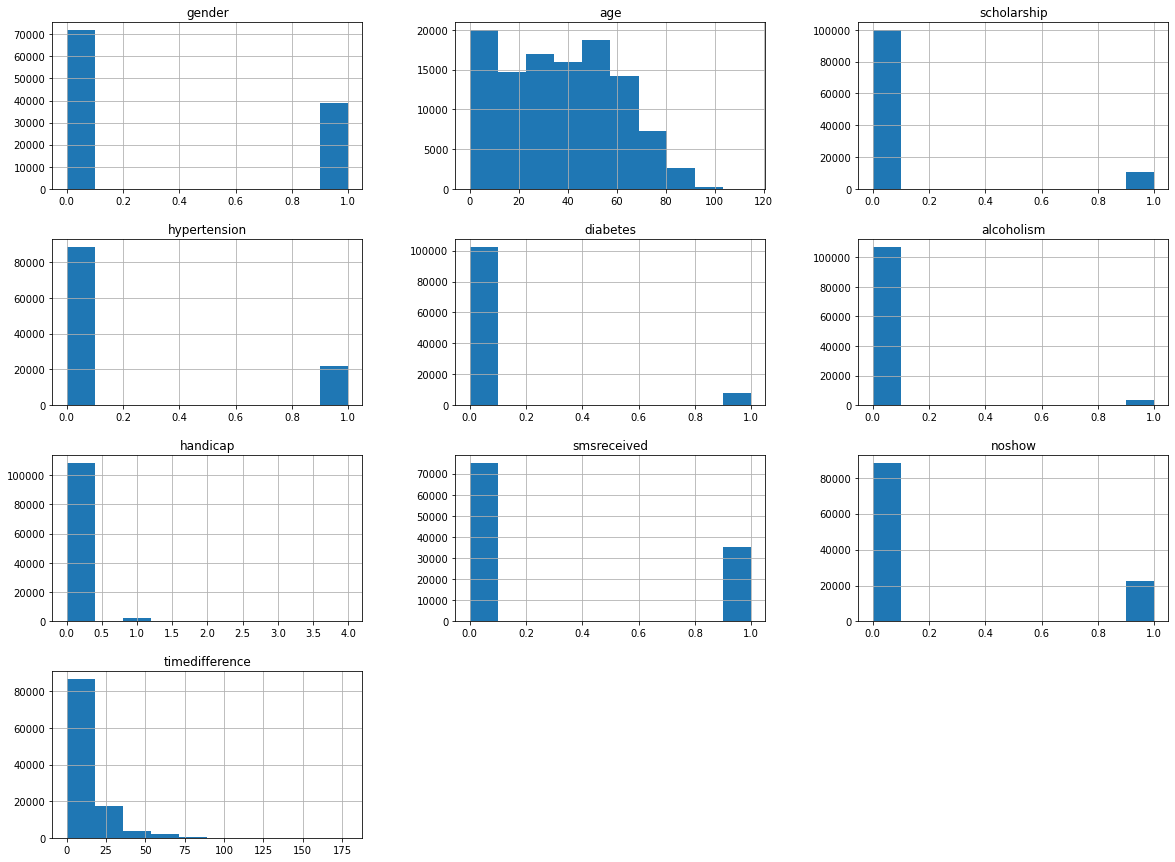

In [114]:
# let's explore the variables by histograms to make some decisions about which varibables to use for the analysis.
df1.hist(figsize=(20,15));


Looking at the histograms we can see that:
 1. Females who get doctor appointments are almost twice the number of the males. A particular gender might be more prone to miss appointments (e.g. male). 
 2. More children get doctor appointments than older people. A particular age range might be more prone to miss appointments.
 3. The proportion of people with scholarship, hypertension, diabetes, alcoholism and handicap are quite low, so I will not focus on those variables for this project - although alcoholism could indicate noshow. 
 4. 1/3rd of the people did not receive SMS message, 2/3rd received SMS message, this might be an important factor for show/noshow. 
 5. More people show up to their appointments (about 80000 as oppposed to 20000 who did not show up), which would be expected. 
 6. Timedifference is right skewed indicating that for the majority of the people the time difference between their scheduled day and appt day would be small. But this variables could be an important factor for show/noshow. 

### Data Cleaning 
Clean Data has 110521 rows (patients) and 12 variables. 

Issues fixed:

1. Variable names (columns) are fixed.
2. Certain columns specific to the patient (Patient ID, Appointment ID) are dropped. 
3. A new varibale called 'timedifferecne" (time difference between ScheduledDay and AppointmentDay) is created since it is a more meaningful measure than the ScheduledDay or AppointmentDay. The data types are changed from string to Datetime for these two variables and then the difference is converted to integer format to be able to use in computations. 
4. The rows containing an incorrect value for age (1) and timedifference (5) are removed from the data set. 
5. Data types for gender and noshow are also changed from object to intereger (binary) for ease of use during computations. 

<a id='eda'></a>
## Exploratory Data Analysis

### Research Question 1: What is the effect of the time difference between scheduled time and appointment time on Show/NoShow?

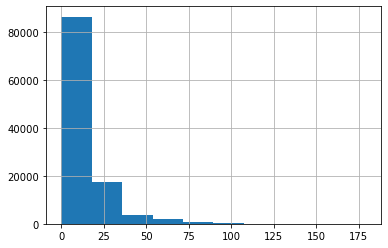

In [115]:
df1['timedifference'].hist();

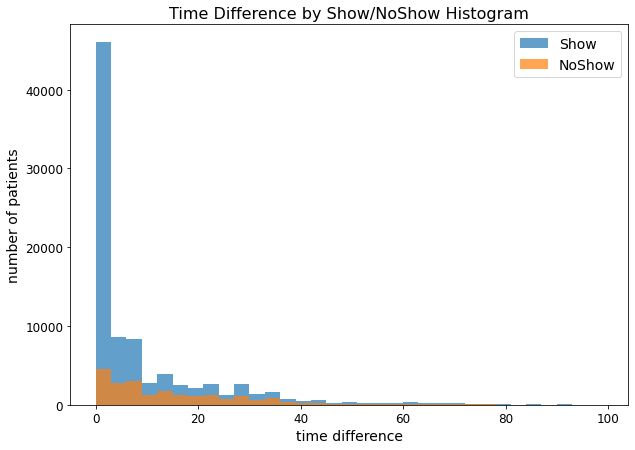

In [116]:
# Plotting count of patient in relation to Time Difference and Show/NoShow

bin_values = np.arange(start=0, stop=100, step=3) # since there was little data past 100, I will ignore those values on the graph
hist1 = df1.groupby('noshow')['timedifference']; # grouped by noshow, exploring the numbers for the timedifference. 

hist1.plot(kind='hist', bins=bin_values, figsize=[10,7], alpha=.7, legend=True) ;
plt.title('Time Difference by Show/NoShow Histogram', fontsize=16)
plt.xlabel ('time difference', fontsize=14)
plt.ylabel ('number of patients', fontsize=14)
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)
plt.legend(labels=['Show', 'NoShow'],fontsize=14);


Looking at the histogram it seems like the proportion of the people showing up for their apppointment are much higher when the time difference is smaller. This shows that if your appopintment is scheduled for a close by date you would be more likely "not" to miss it. One complication is that the total number of patients are also decreasing in size as the timedifference increases. However it still seems like the proportion of no show is relatively higher for the larger time differences compared to smaller time differences, suggesting that if your appointment is scheudled for a later date you would be more likely to miss it. 

In [117]:
# let's look at the numbers again to have a better idea
df1.groupby('timedifference')['noshow'].describe()

,count,mean,std,min,25%,50%,75%,max
timedifference,,,,,,,,
0,38562.0,0.046471,0.210505,0.0,0.0,0.0,0.0,1.0
1,5213.0,0.213505,0.409820,0.0,0.0,0.0,0.0,1.0
2,6725.0,0.238216,0.426023,0.0,0.0,0.0,0.0,1.0
3,2737.0,0.235294,0.424260,0.0,0.0,0.0,0.0,1.0
4,5290.0,0.232703,0.422595,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
155,10.0,0.600000,0.516398,0.0,0.0,1.0,1.0,1.0
162,11.0,0.181818,0.404520,0.0,0.0,0.0,0.0,1.0
169,8.0,0.125000,0.353553,0.0,0.0,0.0,0.0,1.0


Looking into descriptives we can also see that for the timedifference of 0-4 days the means for noshow are closer to 0 (0.046, 0.213, 0.238, 0.235 and 0.232) indicating more people 'show up' to their appointments. On the other hand for the timedifference of 155-179 days the means seem to be farther away from 0 (show) and closer to 1 (noshow) (0.600000 , 0.181818, 0.125000, 0.375000, 0.2000000), suggesting more people tend to not to show up. But one complication is that there is a higher variability among the means in this larger time difference range  - possibly due to the small sample size in this range. So let's explore this a bit more by parsing the timedifference column into three broad levels.

In [118]:
# I choose 0-7 days (1 week), 7-30 days (1 month) and 30-179 days (more than 1 month) as reasonable time intervals. 
bin_edges = [-1, 7, 30, 180]
bin_names = ['0-7days','7-30days', '30-179days']
df1['timeintervals'] = pd.cut(df1['timedifference'], bin_edges, labels=bin_names)

In [119]:
df1['timeintervals']

0            0-7days
1            0-7days
2            0-7days
3            0-7days
4            0-7days
             ...    
110522    30-179days
110523    30-179days
110524    30-179days
110525    30-179days
110526    30-179days
Name: timeintervals, Length: 110521, dtype: category
Categories (3, object): ['0-7days' < '7-30days' < '30-179days']

timeintervals
0-7days       0.135186
7-30days      0.317220
30-179days    0.330025
Name: noshow, dtype: float64


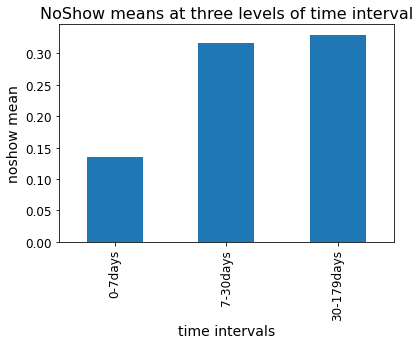

In [120]:
# let's have a look at the means for noshow at three levels of timeinterval
print(df1.groupby('timeintervals')['noshow'].mean())
df1.groupby('timeintervals')['noshow'].mean().plot(kind='bar');
plt.title('NoShow means at three levels of time interval', fontsize=16);
plt.xlabel ('time intervals', fontsize=14)
plt.ylabel ('noshow mean', fontsize=14)
plt.xticks(fontsize=12);  
plt.yticks(fontsize=12);

This graph shows that the mean for noshow is lowest (0.135186) when the time interval is 0-7days - that is the patients are MORE likely to go for the appointment if the time interval is small.

The means for noshow is highest (0.330025) when the  time interval is 30-179days - that is the patients are LESS likely show up for their appointment if more tnan 1 month has passed since they have been scheduled. 

The means for noshow is still high (0.317220) when the  time interval is 7-30days - that is the patients are still LESS likely show up for their appointment in this range compared to 0-7days range. This might suggest that possibly after around 1 week mark the likelihood for not showing up does not change much and it is still lower than 0-7 days. 

### Research Question 2 : What is the effect of receiving or not receiving a text message on Show/NoShow?

smsreceived  noshow
0            0         62509
             1         12530
1            0         25698
             1          9784
Name: noshow, dtype: int64


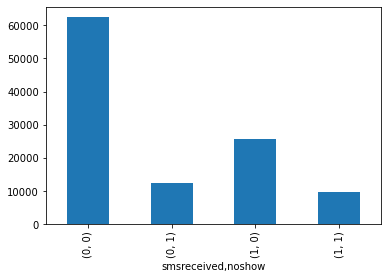

In [121]:
# Let's group by smsreceived and look at the value counts of showing up / not showing up.  
print(df1.groupby('smsreceived')['noshow'].value_counts())
df1.groupby('smsreceived')['noshow'].value_counts().plot(kind='bar');

Based on this descriptive and graph it seems like among those who did not receive an SMS there is a much higher proportion of people who showed up (62509) compared to the people who did not show up (12530). On the other hand, for those who received an SMS, show up is 25698 compared to noshow 9784. The proportion of people who show up seems to be lower for those who received an SMS which is a bit counterintuitive. Let's explore this more with proportions. 

In [122]:
# get value counts for smsreceived based on show/noshow
sms_counts = df1.groupby('smsreceived')['noshow'].value_counts()
sms_counts

smsreceived  noshow
0            0         62509
             1         12530
1            0         25698
             1          9784
Name: noshow, dtype: int64

In [123]:
# get total counts for noshow
total_counts = df1['smsreceived'].value_counts()
total_counts

0    75039
1    35482
Name: smsreceived, dtype: int64

In [124]:
# get proportions by dividing noshow counts to total counts
SMS_proportions = sms_counts[1] / total_counts[1]  # proportion of those who showed up
noSMS_proportions = sms_counts[0] / total_counts[0] # proportion of those who did not show up

In [125]:
SMS_proportions, noSMS_proportions

(noshow
 0    0.724255
 1    0.275745
 Name: noshow, dtype: float64,
 noshow
 0    0.83302
 1    0.16698
 Name: noshow, dtype: float64)

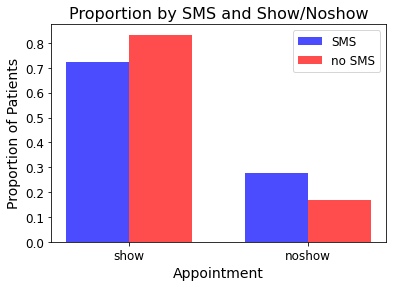

In [126]:
# let's make a graph
ind = np.arange(len(SMS_proportions)) 
width = 0.35 

# plot bars
blue_bars = plt.bar(ind, SMS_proportions, width, color='b', alpha=.7, label='SMS');
red_bars = plt.bar(ind + width, noSMS_proportions, width, color='r', alpha=.7, label='no SMS');

# title and labels
plt.ylabel('Proportion of Patients',fontsize=14)
plt.xlabel('Appointment',fontsize=14)
plt.title('Proportion by SMS and Show/Noshow',fontsize=16)
locations = ind + width / 2  # xtick locations
labels = ['show', 'noshow']  # xtick labels
plt.xticks(locations, labels, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12);

Among the patients who showed up, most of them did not receive an SMS, and among the patients who did NOT show up, most of them received an SMS. This is counterintuitive, because one would expect a text message to be helpful so that more people would remember and actually show up for their appointment. 

Maybe we see this pattern because the patients are more likely to receive a text message when they have a longer wait time between their scheduling and appointment day? Lets investigate this point.

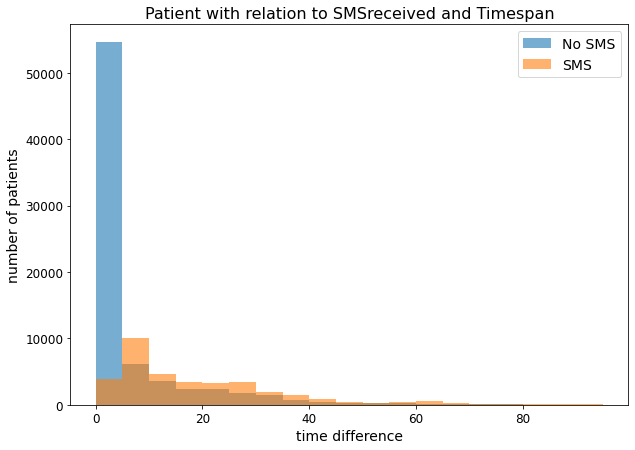

In [127]:
# Plotting count of patient in relation to SMSreceived and Time Difference

bin_values = np.arange(start=0, stop=100, step=5) # since there is little data past 100, i will ignore those on the graph
hist1 = df1.groupby('smsreceived')['timedifference']; 
hist1.plot(kind='hist', bins=bin_values, figsize=[10,7], alpha=.6, legend=True) ;
plt.title('Patient with relation to SMSreceived and Timespan', fontsize=16)
plt.xlabel ('time difference', fontsize=14)
plt.ylabel ('number of patients', fontsize=14)
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)
plt.legend(labels=['No SMS', 'SMS'], fontsize=14);

Based on this graph as the time difference is increasing, the proportion of those who received SMS also seems to be increasing. 

In [128]:
# let's also look at the timeinterval variable
df1.groupby('smsreceived')['timeintervals'].value_counts().sort_index()

smsreceived  timeintervals
0            0-7days          59199
             7-30days         11872
             30-179days        3968
1            0-7days          11548
             7-30days         17524
             30-179days        6410
Name: timeintervals, dtype: int64

As we expected, it turned out that those with a longer timeintervals between scheduled date and appointment date are more likely to receive an SMS. And those with the shortest timeinterval are less likely to receive an SMS. Therefore, there probably is a correlation between timedifference, SMSreceived and noshow. 

In the end, we have shown that time difference and SMSreceived have an effect on whether the patient would show up or not. Patients are more likely to show up when the time interval is smaller, and when they did not received an SMS message (those with short time interval are less likely to get a message as well). 

### Research Question 3 : What is the effect of gender on Show/NoShow?

In [129]:
# value counts of gender by noshow
gender_counts = df1.groupby('gender')['noshow'].value_counts()
gender_counts

gender  noshow
0       0         57245
        1         14591
1       0         30962
        1          7723
Name: noshow, dtype: int64

In [130]:
# total counts of each gender. 
total_counts = df1['gender'].value_counts()
total_counts

0    71836
1    38685
Name: gender, dtype: int64

In [131]:
# get proportions by dividing gender counts by total.
female_proportions = gender_counts[0] / total_counts[0]
male_proportions = gender_counts[1] / total_counts[1]

In [132]:
female_proportions, female_proportions

(noshow
 0    0.796885
 1    0.203115
 Name: noshow, dtype: float64,
 noshow
 0    0.796885
 1    0.203115
 Name: noshow, dtype: float64)

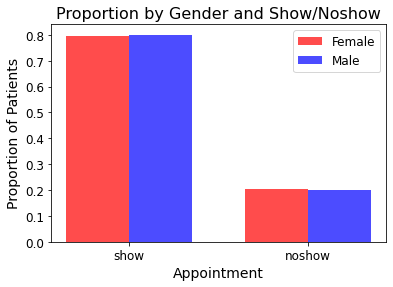

In [133]:
# plot bar for effect of gender
ind = np.arange(len(female_proportions))  
width = 0.35  

red_bars = plt.bar(ind, female_proportions, width, color='r', alpha=.7, label='Female');
white_bars = plt.bar(ind + width, male_proportions, width, color='b', alpha=.7, label='Male');

plt.ylabel('Proportion of Patients',fontsize=14)
plt.xlabel('Appointment',fontsize=14)
plt.title('Proportion by Gender and Show/Noshow',fontsize=16)
locations = ind + width / 2  
labels = ['show', 'noshow']  
plt.xticks(locations, labels, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12);

Based on this graph we can infer that it's about the same ratio of female to male for both show and noshow. So we can conclude that gender has no effect on noshow. The same proportion of males and females show up or do not show up for their appointments.  

<a id='conclusions'></a>
## Conclusions
The exploratory analysis indicated that:

1. The time difference between scheduling day and appointment day seems to have an effect on whether the patients would show up or not show up for their appointments. The larger the time interval, it is the less likely that they would show up.
    
2. Whether patients received an SMS or not seems to have an effect on whether the patients would shop up or not show up for their appointments. Among the patients who did NOT show up more received an SMS - that is if a patient has received an SMS, they appear to be less likely to show up. This is counterintuitive but it makes sense if those who did receive an SMS also had a longer wait time between the scheduling and appointment. 

3. The time difference between scheduling day and appointment day, and whether patients received an SMS seemed to be related. Those with longer wait times were more likely to receive an SMS, compared to those with shorter wait times, who were less likely to receive an SMS.

4. Finally gender did not seem to have any effect on whether a patient would show up or not. 

Limitations:
1. During the data wrangling period we have realized that many patients had repeated visit data. Ideally when exploring the effect of gender (or any other patient specific information) those repeat data should have been removed and only one data point per patient ID should have been kept (to avoid the assumption of independence). 

2. There were many other variables that were not analyzed such as alcoholism or neighbourhood, which could also be good predictors for show/noshow. 